# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучим общую информацию. 

In [1]:
# Импортируем необходимые библиотеки 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

None

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


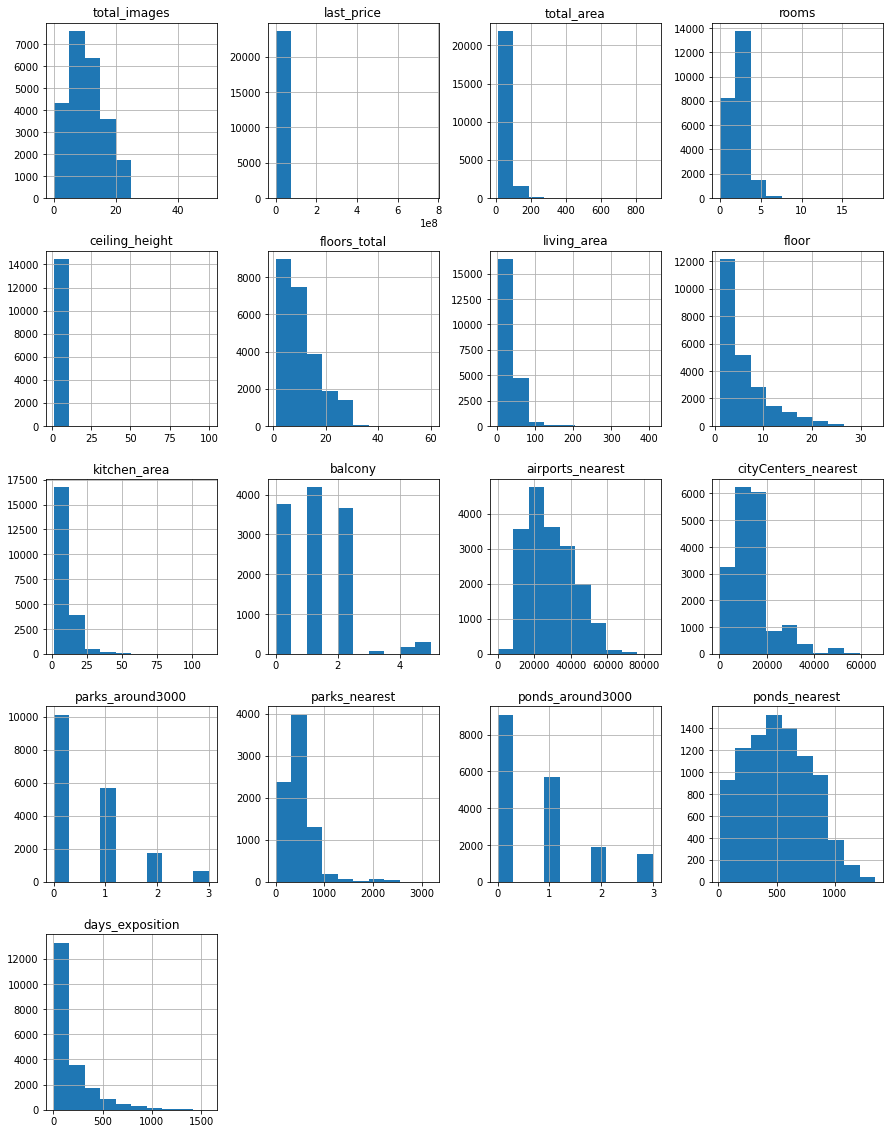

In [2]:
# Загружаем данные из файла в датафрейм.
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
pd.options.display.max_columns = 30

# Изучаем общую информацию о полученном датафрейме.
display(data.info())
display(data.head(5))

# Строим общую гистограмму для всех числовых столбцов таблицы.
data.hist(figsize=(15,20));

Изучив данные, можем сделать несколько выводов:
1. В датасете 23699 строк и 22 столбца.
2. Из 22-х столбцов заполнены без пропусков 8: 'total_images', 'last_price', 'total_area', 'first_day_exposition', 'rooms', 'floor', 'studio', 'open_plan'. 
3. В столбце 'is_apartment значительное количество пропусков. Их можно заменить на False, так как продавец скорее всего отметил бы, что недвижимость является апартаментной. Аналогично можно поступить с пропусками в столбце 'balcony', заменив пропуски на значение 0.
4. Значения в столбце 'first_day_exposition' необходимо привести к формату datetime, в столбцах 'floors_total', 'balcony' - к формату int.


### Предобработка данных

Заполняем пропущенные значения:

In [3]:
# проверяем количество и долю (в процентах) пропусков в каждом столбце датасета. 
pd.concat([data.isna().sum(), (data.isna().sum()/len(data.index)*100)], axis=1)

,0,1
total_images,0,0.000000
last_price,0,0.000000
total_area,0,0.000000
first_day_exposition,0,0.000000
rooms,0,0.000000
ceiling_height,9195,38.799105
floors_total,86,0.362885
living_area,1903,8.029875
floor,0,0.000000
is_apartment,20924,88.290645


In [4]:
# Заполняем пропуски в столбце 'ceiling_height' - высота потолков:
# 38% пропусков это существенная доля, поэтому удаление строк с пропущенными значениями высоты потолка может исказить результаты 
# исследования. Заполним пропуски медианным значением.

data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

# Теперь избавимся от опечаток и аномальных значений (потолки ниже 2-х метров и выше 6 метров)

data = data.query('ceiling_height > 2 and ceiling_height <= 10')

In [5]:
# Заполняем пропуски в столбце 'floors_total' - количество этажей в здании:
# В этом столбце пропусков всего 0.36%, поэтому удаление строк с пропусками не повлияет на исследование так же, как и заполнение их медианным значением.

data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median())

In [6]:
# Заполняем пропуски в столбце "living_area". Здесь всего 8% строк с пропусками, 
# можем удалить их или заменить пропуски медианным значением

data['living_area'] = data['living_area'].fillna(data['living_area'].median())

In [7]:
# Заполняем пропуски в столбце "is_apartment". Заменяем их на False, так как 
# продавец скорее всего отметил бы, что недвижимость является апартаментной

data['is_apartment'] = data['is_apartment'].fillna(False)

In [8]:
# Заполняем пропуски в столбце "kitchen_area" по аналогии с пропусками в столбце "is_apartment".
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())

In [9]:
# Заменяем пропуски в столбце 'balcony' - количество балконов:
# Предположим, что пропуски в этом столбце говорят о том, что балконов нет, поэтому продавец и не заполнял данную графу.
data['balcony'] = data['balcony'].fillna(0)



In [10]:
# Пропуски в столбце 'locality_name' мы заполнить не сможем, поэтому удаляем строки с пропущенными значениями.
data = data.dropna(subset=['locality_name'])

In [11]:
# Еще раз проверяем количество пропусков
pd.concat([data.isna().sum(), (data.isna().sum()/len(data.index)*100)], axis=1)

,0,1
total_images,0,0.000000
last_price,0,0.000000
total_area,0,0.000000
first_day_exposition,0,0.000000
rooms,0,0.000000
ceiling_height,0,0.000000
floors_total,0,0.000000
living_area,0,0.000000
floor,0,0.000000
is_apartment,0,0.000000


После заполнения пропусков тип данных в столбцах 'balcony' и 'floors_total' следует заменить на целочисленный, т.к. количеством балконов и этажей может быть только целое число. В столбце 'first_day_exposition' меняем тип данных на datetime.

In [12]:
# меняем тип данных столбцов 'balcony' и 'floors_total' на int
data['balcony'] = data['balcony'].astype(int)
data['floors_total'] = data['floors_total'].astype(int)

# меняем формат даты размещения объявления
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M')
#data.head(5)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23611 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23611 non-null  int64         
 1   last_price            23611 non-null  float64       
 2   total_area            23611 non-null  float64       
 3   first_day_exposition  23611 non-null  datetime64[ns]
 4   rooms                 23611 non-null  int64         
 5   ceiling_height        23611 non-null  float64       
 6   floors_total          23611 non-null  int64         
 7   living_area           23611 non-null  float64       
 8   floor                 23611 non-null  int64         
 9   is_apartment          23611 non-null  bool          
 10  studio                23611 non-null  bool          
 11  open_plan             23611 non-null  bool          
 12  kitchen_area          23611 non-null  float64       
 13  balcony         

Переходим к названиям населенных пунктов. Здесь довольно много неявных дубликатов. Например, 
«поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» — это обозначения одних и тех же населённых пунктов.

In [13]:
# подсчёт явных дубликатов
data.duplicated().sum()

0

In [14]:
# Посмотрим на все существующие названия населенных пунктов и избавимся от неявных дубликатов:
locality_data = data.sort_values(by = 'locality_name')
locality_data['locality_name'].unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [15]:
data['locality_name'] = data['locality_name'].str.replace('ё','е')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа','поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок при железнодорожной станции','поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок станции','поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок')
data['locality_name'] = data['locality_name'].str.replace('коттеджный поселок','поселок')
data['locality_name'] = data['locality_name'].str.replace('садовое некоммерческое товарищество','садовое товарищество')
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество','садовое товарищество')

In [16]:
# Проверим отсутствие неявных дубликатов:
locality_data = data.sort_values(by = 'locality_name')
locality_data['locality_name'].unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалево',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',
       'деревня Бегуницы', 'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Большой Сабск', 'деревня Бор',
       'деревня Борисова Грива', 'деревня Ваганово', 'деревня Вартемяги',
       'деревня Вахнова Кара', 'деревня Выскатка

In [17]:
# проверка на отсутствие дубликатов
data.duplicated().sum()

0

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23611 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23611 non-null  int64         
 1   last_price            23611 non-null  float64       
 2   total_area            23611 non-null  float64       
 3   first_day_exposition  23611 non-null  datetime64[ns]
 4   rooms                 23611 non-null  int64         
 5   ceiling_height        23611 non-null  float64       
 6   floors_total          23611 non-null  int64         
 7   living_area           23611 non-null  float64       
 8   floor                 23611 non-null  int64         
 9   is_apartment          23611 non-null  bool          
 10  studio                23611 non-null  bool          
 11  open_plan             23611 non-null  bool          
 12  kitchen_area          23611 non-null  float64       
 13  balcony         

В результате предобработки данных в датасете осталось 23611 строк. Тип данных в столбцах 'balcony', 'floors_total' и 'first_day_exposition' был изменен. Неявные дубликаты в столбце 'locality_name' были устранены.

Изучим аномалии в столбцах со стоимостью квартиры, количеством комнат и общей площадью. 

In [19]:
# Избавимся от аномальных значений общей стоимости объектов. Аномальными будем считать значения ниже 100 тысяч рублей и выше 100 млн рублей. 
data = data.query('100000 < last_price < 100000000')
last_price_data = data.sort_values(by = 'last_price')
display(last_price_data['last_price'].unique())

array([  430000.,   440000.,   450000., ..., 96000000., 98000000.,
       99000000.])

In [20]:
# Избавимся от аномальных значений количества комнат (больше десяти). 

data = data.query('0 < rooms < 10')
rooms_data = data.sort_values(by = 'rooms')
display(rooms_data['rooms'].unique())

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [21]:
# Избавимся от аномальных значений общей площади. Будем считать аномальной площадь меньше 10 кв м и больше 400 кв м. 

data = data.query('10 < total_area < 400')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23352 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23352 non-null  int64         
 1   last_price            23352 non-null  float64       
 2   total_area            23352 non-null  float64       
 3   first_day_exposition  23352 non-null  datetime64[ns]
 4   rooms                 23352 non-null  int64         
 5   ceiling_height        23352 non-null  float64       
 6   floors_total          23352 non-null  int64         
 7   living_area           23352 non-null  float64       
 8   floor                 23352 non-null  int64         
 9   is_apartment          23352 non-null  bool          
 10  studio                23352 non-null  bool          
 11  open_plan             23352 non-null  bool          
 12  kitchen_area          23352 non-null  float64       
 13  balcony         

В результате предобработки данных было удалено из таблицы 347 строк, что составляет 1.4% всего датасета. Исследование продолжим с таблицей, которая состоит из 23352 строк. 

### Посчет и добавление в таблицу новых столбцов

In [22]:
# Добавляем столбец с ценой одного квадратного метра. Для этого делим стоимость квартиры на ее площадь

data['price_per_square'] = data['last_price'] / data['total_area']
display(data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,30.0,9,False,False,False,9.1,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000


In [23]:
# Добавляем столбцы с днем, месяцем и годом публикации объявлений
data['publication_weekday'] = data['first_day_exposition'].dt.weekday
data['publication_month'] = data['first_day_exposition'].dt.month
data['publication_year'] = data['first_day_exposition'].dt.year
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square,publication_weekday,publication_month,publication_year
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,30.0,9,False,False,False,9.1,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018


In [24]:
# Добавляем в таблицу столбец с типом этажа квартиры
def floor_category(row):
    floor = row['floor']
    floors_total = row['floors_total']
    
    if floor == 1:
        return 'Первый'
    if floor == floors_total:
        return 'Последний'
    return 'Другой'
        
data['floor_type'] = data.apply(floor_category, axis = 1)
#data.head(10)
#data['floor_type'].unique()

In [25]:
# Добавляем столбец со значением расстояния до центра в километрах:
# В этом столбце есть много пропусков, которые мы никак не можем (не должны) заполнять. Однако для того, 
# чтобы перевести расстояние в километры, заполним пропуски нулями, переведем значения, а затем удалим нули и вернем пропуски

data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)

data['center_kms'] = (data['cityCenters_nearest'] / 1000).astype(int)

data.loc[data['cityCenters_nearest'] == 0,'cityCenters_nearest'] = None     
data.loc[data['center_kms'] == 0,'center_kms'] = None

display(data.head(10))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square,publication_weekday,publication_month,publication_year,floor_type,center_kms
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.00,8,False,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,Другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,2.65,11,18.60,1,False,False,False,11.00,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,Первый,18.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5,34.30,4,False,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,Другой,13.0
3,0,64900000.0,159.00,2015-07-24,3,2.65,14,30.00,9,False,False,False,9.10,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,Другой,6.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.00,13,False,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,Другой,8.0
5,10,2890000.0,30.40,2018-09-10,1,2.65,12,14.40,5,False,False,False,9.10,0,поселок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065.789474,0,9,2018,Другой,NaN
6,6,3700000.0,37.30,2017-11-02,1,2.65,26,10.60,6,False,False,False,14.40,1,поселок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195.710456,3,11,2017,Другой,19.0
7,5,7915000.0,71.60,2019-04-18,2,2.65,24,30.00,22,False,False,False,18.90,2,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,110544.692737,3,4,2019,Другой,11.0
8,20,2900000.0,33.16,2018-05-23,1,2.65,27,15.43,26,False,False,False,8.81,0,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,87454.764777,2,5,2018,Другой,NaN
9,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.60,7,False,False,False,6.50,2,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,88524.590164,6,2,2017,Другой,15.0


В результате вычислений в таблицу были добавлены следующие столбцы: цена одного квадратного метра, день публикации объявления (0 - понедельник, 1 - вторник и т.д.), месяц публикации объявления, год публикации объявления, тип этажа квартиры (значения — «первый», «последний», «другой»), расстояние в км до центра города.

Теперь можно переходить к исследовательскому анализу.

### Исследовательский анализ данных

count    23352.000000
mean        59.818387
std         31.386489
min         12.000000
25%         40.100000
50%         52.000000
75%         69.717500
max        399.000000
Name: total_area, dtype: float64

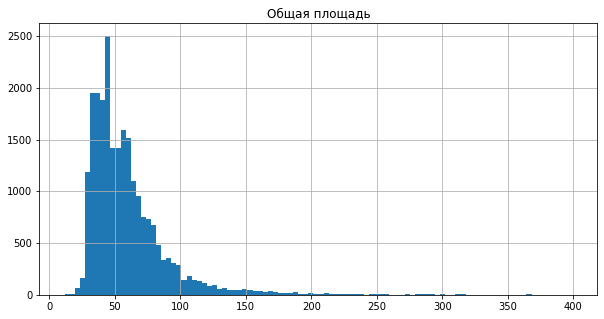

In [26]:
# Для анализа общей площащи посторим гистограмму

display(data['total_area'].describe())
data.hist('total_area', bins = 100, figsize = (10, 5));
plt.title('Общая площадь')
plt.show()

Как следует из данных, среди 23352 квартир больше всего помещений площадью около 60 кв.м. Самая маленькая квартира из представленных имеет площадь всего 12 кв.м., самая большая - 399 кв.м. (аномальные значения были удалены). 

count    23352.000000
mean        33.845802
std         19.327928
min          2.000000
25%         19.200000
50%         30.000000
75%         41.100000
max        255.700000
Name: living_area, dtype: float64

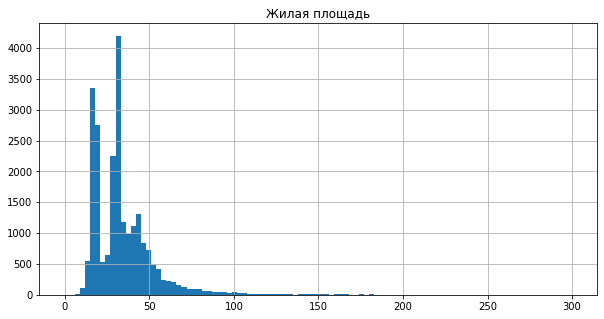

array([  2. ,   3. ,   5.4, ..., 248.5, 250. , 255.7])

In [27]:
# Далее анализируем жилую площадь

display(data['living_area'].describe())
data.hist('living_area', range = (0, 300), bins = 100, figsize = (10, 5));
plt.title('Жилая площадь')
plt.show()
living_data = data.sort_values(by = 'living_area')
display(living_data['living_area'].unique())

Проведя анализ и изучив график, можно сделать вывод о том, что большая часть квартир имеет жилую площадь около 34 кв.м. При этом немалую долю составляют квартиры с жилой площадью до 20 кв.м. Скорее всего, это малосемейные квартиры.

count    23352.000000
mean        10.377587
std          5.419548
min          1.300000
25%          7.300000
50%          9.100000
75%         11.500000
max        107.000000
Name: kitchen_area, dtype: float64

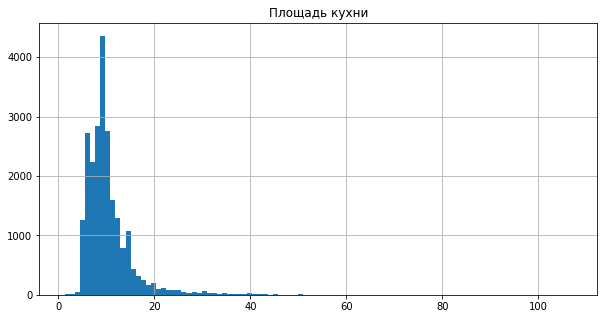

array([  1.3 ,   2.  ,   2.3 ,   2.4 ,   2.89,   3.  ,   3.2 ,   3.3 ,
         3.4 ,   3.5 ,   3.7 ,   3.8 ,   4.  ,   4.1 ,   4.2 ,   4.3 ,
         4.4 ,   4.5 ,   4.6 ,   4.7 ,   4.8 ,   4.9 ,   5.  ,   5.04,
         5.06,   5.1 ,   5.14,   5.2 ,   5.21,   5.23,   5.25,   5.28,
         5.29,   5.3 ,   5.31,   5.33,   5.35,   5.4 ,   5.42,   5.44,
         5.47,   5.49,   5.5 ,   5.53,   5.59,   5.6 ,   5.61,   5.62,
         5.64,   5.65,   5.68,   5.7 ,   5.74,   5.75,   5.78,   5.8 ,
         5.82,   5.85,   5.86,   5.9 ,   5.91,   6.  ,   6.02,   6.03,
         6.1 ,   6.16,   6.19,   6.2 ,   6.22,   6.23,   6.24,   6.25,
         6.26,   6.27,   6.28,   6.3 ,   6.31,   6.33,   6.35,   6.36,
         6.37,   6.4 ,   6.47,   6.5 ,   6.55,   6.58,   6.6 ,   6.61,
         6.62,   6.65,   6.7 ,   6.72,   6.73,   6.76,   6.77,   6.8 ,
         6.82,   6.83,   6.84,   6.86,   6.9 ,   6.91,   6.93,   6.95,
         7.  ,   7.02,   7.03,   7.06,   7.09,   7.1 ,   7.12,   7.15,
      

In [28]:
# Далее исследуем площадь кухни

display(data['kitchen_area'].describe())
data.hist('kitchen_area', bins = 100, figsize = (10, 5));
plt.title('Площадь кухни')
plt.show()
kitchen_data = data.sort_values(by = 'kitchen_area')
display(kitchen_data['kitchen_area'].unique())

В результате анализа графика видно, что наибольшая часть квартир из таблицы имеет площадь кухни около 10.4 кв.м. Есть квартиры с площадью кухни менее 5 кв.м - скорее всего, это квартиры-студии или малосемейные квартиры.

count    2.335200e+04
mean     6.235787e+06
std      6.253607e+06
min      4.300000e+05
25%      3.450000e+06
50%      4.650000e+06
75%      6.799250e+06
max      9.900000e+07
Name: last_price, dtype: float64

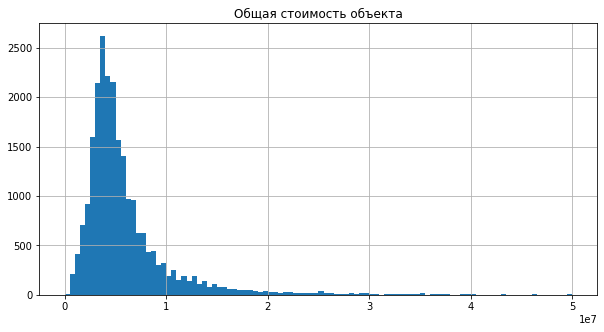

In [29]:
# Исследуем цену объектов

display(data['last_price'].describe())
data.hist('last_price', range = (0, 50000000), bins = 100, figsize = (10, 5));
plt.title('Общая стоимость объекта')
plt.show()

Судя по графику, большая часть квартир таблицы была продана примерно за 6.25 млн. Минимальная цена за квартиру, указанная в таблице - 430 тысяч, самые дорогие объекты стоят около 100 млн и дороже. Аномальные значения цен были удалены из таблицы, чтобы они не искажали результаты исследования. 

count    23352.000000
mean         2.075925
std          1.026988
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          9.000000
Name: rooms, dtype: float64

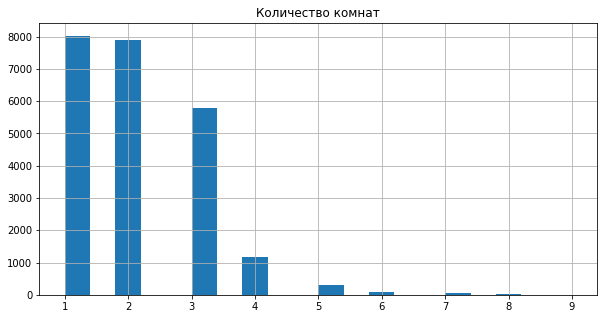

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [30]:
# Анализируем количество комнат

display(data['rooms'].describe())
data.hist('rooms', bins = 20, figsize = (10, 5));
plt.title('Количество комнат')
plt.show()
rooms_data = data.sort_values(by = 'rooms')
display(rooms_data['rooms'].unique())

Как ни странно, наибольшая часть квартир в таблице - однокомнатные и двухкомнатные, а также чуть меньшую долю составляют трехкомнатные квартиры. Аномальные значения комнат были удалены из датасета.

count    23352.000000
mean         2.696352
std          0.226442
min          2.200000
25%          2.600000
50%          2.650000
75%          2.700000
max          8.300000
Name: ceiling_height, dtype: float64

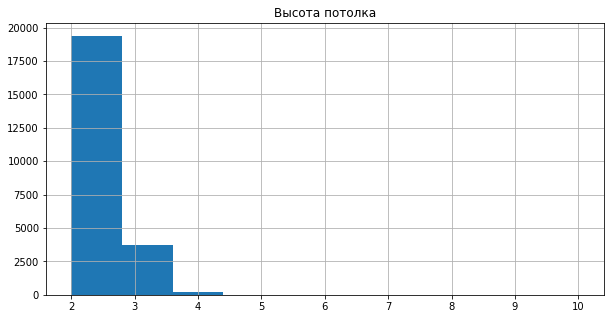

array([2.2 , 2.25, 2.3 , 2.34, 2.4 , 2.45, 2.46, 2.47, 2.48, 2.49, 2.5 ,
       2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 , 2.61,
       2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71, 2.72,
       2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82, 2.83,
       2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93, 2.94,
       2.95, 2.96, 2.97, 2.98, 2.99, 3.  , 3.01, 3.02, 3.03, 3.04, 3.05,
       3.06, 3.07, 3.08, 3.09, 3.1 , 3.11, 3.12, 3.13, 3.14, 3.15, 3.16,
       3.17, 3.18, 3.2 , 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28,
       3.29, 3.3 , 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39,
       3.4 , 3.42, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5 , 3.51, 3.52,
       3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.6 , 3.62, 3.63, 3.65,
       3.66, 3.67, 3.68, 3.69, 3.7 , 3.75, 3.76, 3.78, 3.8 , 3.83, 3.84,
       3.85, 3.86, 3.87, 3.88, 3.9 , 3.93, 3.95, 3.98, 4.  , 4.06, 4.1 ,
       4.14, 4.15, 4.19, 4.2 , 4.25, 4.3 , 4.37, 4.

In [31]:
# Далее исследуем высоту потолков

display(data['ceiling_height'].describe())
data.hist('ceiling_height', bins = 10, range = (2, 10), figsize = (10, 5));
plt.title('Высота потолка')
plt.show()
height_data = data.sort_values(by = 'ceiling_height')
display(height_data['ceiling_height'].unique())

В таблице представлены обработанные значения высоты потолков (от 2 м до 10 м, остальные удалены). Минимальная высота потолка - 2.2 м. Максимальная высота - 8.3 м. Большая часть квартир имеет высоту потолка равную 2.6 м.

count    23352.000000
mean         5.871831
std          4.864704
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

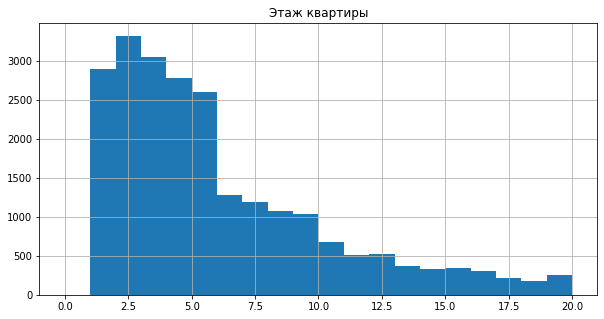

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [32]:
# Далее переходим к анализу этажа квартир

display(data['floor'].describe())
data.hist('floor', bins = 20, range = (0, 20), figsize = (10, 5));
plt.title('Этаж квартиры')
plt.show()
floor_data = data.sort_values(by = 'floor')
display(floor_data['floor'].unique())

Как видно на графике, наибольшая часть квартир расположена на 1 - 6 этажах. Больше всего объявлений о продаже квартир, расположенных на втором этаже. Среднее значение этажа равно 6, самая высокая квартира расположена на 33 этаже.

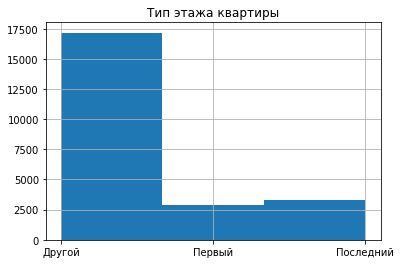

In [33]:
# Исследуем типы этажей

data['floor_type'].hist(bins = 3);
plt.title('Тип этажа квартиры')
plt.show()

Очевидно, наибольшая часть квартир расположена ни на первом, ни на последнем этажах. Из графика видно, что квартир на последнем этаже немного больше, чем квартир с первого этажа.

count    23352.000000
mean        10.629325
std          6.555768
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

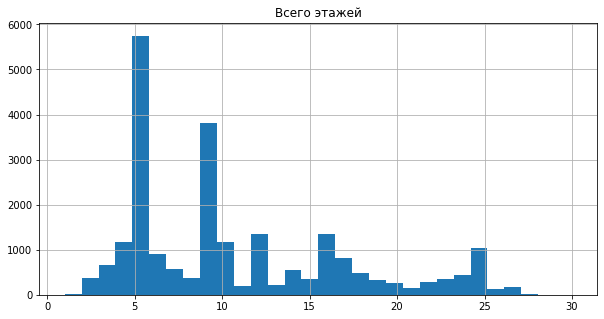

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 34, 35, 36, 52,
       60])

In [34]:
# Далее на очереди для анализа количество этажей

display(data['floors_total'].describe())
data.hist('floors_total', bins = 30, range = (1, 30), figsize = (10, 5));
plt.title('Всего этажей')
plt.show()
floors_total_data = data.sort_values(by = 'floors_total')
display(floors_total_data['floors_total'].unique())

Среди объявлений, представленных в таблице, наибольшее количество зданий имеет 5 и 9 этажей. Самое высокое здание, в котором расположена одна из квартир датасета имеет 60 этажей.

count    17938.000000
mean     14234.758167
std       8619.606551
min        181.000000
25%       9289.000000
50%      13118.000000
75%      16298.750000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

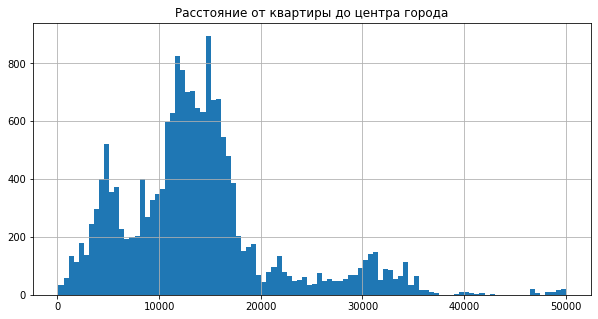

array([  181.,   208.,   215., ..., 65952., 65968.,    nan])

In [35]:
# Переходим к изучению данных о расстоянии от квартиры до центра города, ближайшего парка и аэропорта в метрах

display(data['cityCenters_nearest'].describe())
data.hist('cityCenters_nearest', bins = 100, range = (100, 50000), figsize = (10, 5));
plt.title('Расстояние от квартиры до центра города')
plt.show()
center_data = data.sort_values(by = 'cityCenters_nearest')
display(center_data['cityCenters_nearest'].unique())

На графике видно, что наибольшая доля квартир расположена на расстоянии от 10 до 15 км до центра города. Наибольшее значение равно примерно 66 км, наиболее близкое расстояние от квартиры до центра равно 181 м.

count    17917.000000
mean     28839.281520
std      12649.276234
min          0.000000
25%      18574.000000
50%      26786.000000
75%      37351.000000
max      84869.000000
Name: airports_nearest, dtype: float64

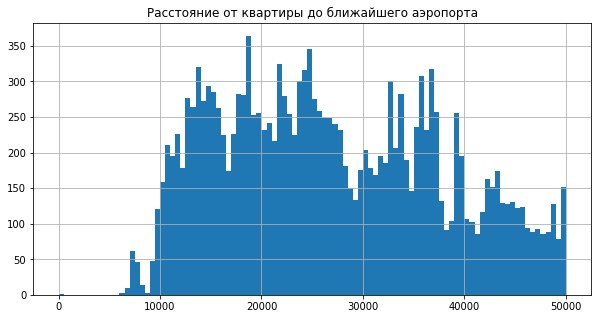

array([    0.,  6450.,  6914., ..., 84853., 84869.,    nan])

In [36]:
display(data['airports_nearest'].describe())
data.hist('airports_nearest', bins = 100, range = (0, 50000), figsize = (10, 5));
plt.title('Расстояние от квартиры до ближайшего аэропорта')
plt.show()
airport_data = data.sort_values(by = 'airports_nearest')
display(airport_data['airports_nearest'].unique())

Изучив данные, можно сделать вывод о том, что наибольшая доля квартир расположена на расстоянии 20 - 25 км от ближайшего аэропорта. В данных есть нулевое значение. Помимо него минимальное расстояние от квартиры до аэропорта равно 6450 м. Наибольшее значение расстояние от жилого помещения до аэропорта равно примерно 85 км.

count    7978.000000
mean      490.858110
std       343.367296
min         1.000000
25%       288.000000
50%       454.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

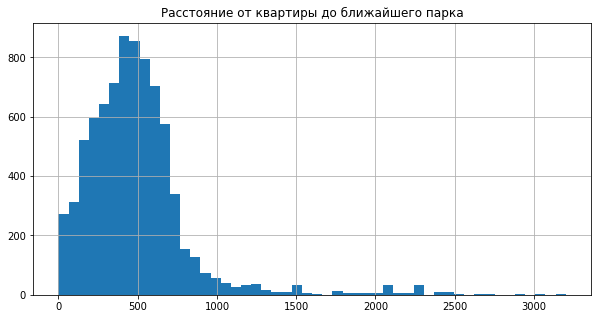

In [37]:
display(data['parks_nearest'].describe())
data.hist('parks_nearest', bins = 50, range = (0, 3200), figsize = (10, 5));
plt.title('Расстояние от квартиры до ближайшего парка')
plt.show()

Изучив график, можно сделать вывод о том, что большинство квартир, представленных в таблице, располагаются в пределах 1 км от ближайшего парка. Минимальное значение расстояния равно 1 м, максимальное расстояние от квартиры до парка равно 3190 м.

count    23352.000000
mean         2.567018
std          1.789667
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: publication_weekday, dtype: float64

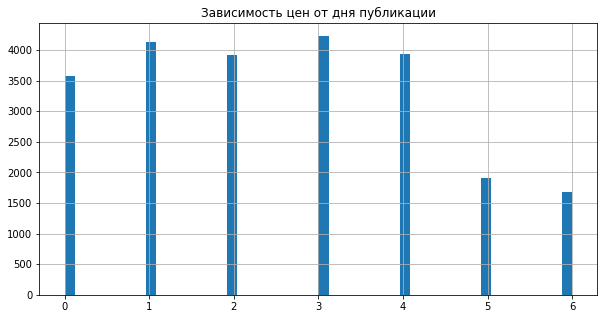

In [38]:
# Переходим к изучению данных, связанных с днем недели и месяцем публикации объявлений


display(data['publication_weekday'].describe())
data.hist('publication_weekday', bins = 50, range = (0, 6), figsize = (10, 5));
plt.title('Зависимость цен от дня публикации')
plt.show()

По графику видно, что объявления реже публикуются в выходные дни. Чаще всего объявления о продаже публикуются во вторник и четверг.

count    23352.000000
mean         6.397525
std          3.490781
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: publication_month, dtype: float64

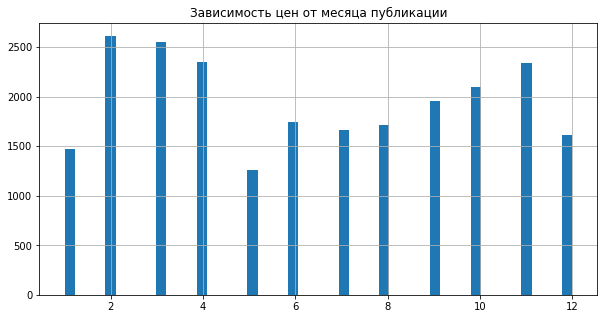

In [39]:
display(data['publication_month'].describe())
data.hist('publication_month', bins = 50, range = (1, 12), figsize = (10, 5));
plt.title('Зависимость цен от месяца публикации')
plt.show()

Судя по графику, меньше всего объявлений опубликовано в мае, январе и декабре, а больше всего в феврале, марте, апреле и ноябре.

count    20207.000000
mean       181.126293
std        219.837106
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

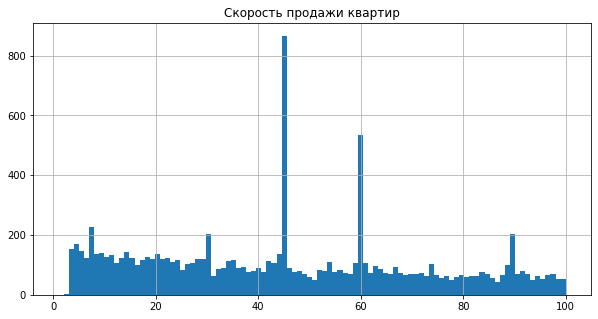

Медианное значение: 96.0
Среднее значение: 181.12629286880784


In [40]:
# Изучаем, как быстро продавались квартиры. Для этого построим гистограмму, вычислим среднее и медианное значения.
display(data['days_exposition'].describe())
data['days_exposition'].hist(bins = 100, range = (1, 100), figsize = (10, 5));
plt.title('Скорость продажи квартир')
plt.show()
print('Медианное значение:', data['days_exposition'].median())
print('Среднее значение:', data['days_exposition'].mean())

В результате анализа можно сказать, что продажа квартиры занимает обычно от сорока до двухсот дней с момента публикации объявления. В таблице представлены квартиры, которые были проданы как быстрее обычного (до 40 дней), так и намного дольше (более 4 лет). Среднее время, которое "висит" объявление о продаже квартиры, равняется примерно 180 дням. В то же время медианное значение равно 95. Медиана более устойчива к аномальным значениям и выбросам, а значит является более объективным показателем.

In [41]:
# Выясним, какие факторы больше всего влияют на общую (полную) стоимость объекта. Начнем с общей площади.

print(data['last_price'].corr(data['total_area']))

0.7612466588319027


Зависимость между общей площадью объекта и его ценой существует. Это подтверждается тем, что коэффициент корреляции больше 0.5

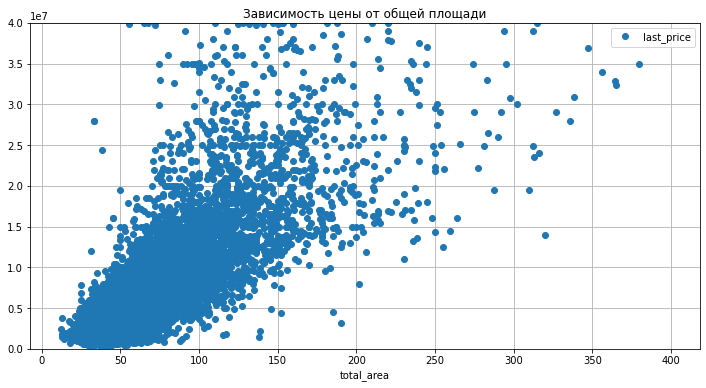

In [42]:
# Построим диаграмму рассеяния. На оси х отметим значения площади, на оси у - цены. 

(data
    .query('total_area < 400')
    .plot(x='total_area', y='last_price', 
          ylim=(0, 40000000), style='o', grid=True, figsize=(12, 6))
)
plt.title('Зависимость цены от общей площади')
plt.show()

На диаграмме видна прямая зависимость цены объекта от его площади. Цены квартир общей площадью выше 150 кв м очень редко опускается ниже 10 млн рублей.

In [43]:
print(data['last_price'].corr(data['living_area']))

0.6259979367794565


Зависимость есть, но менее значительная

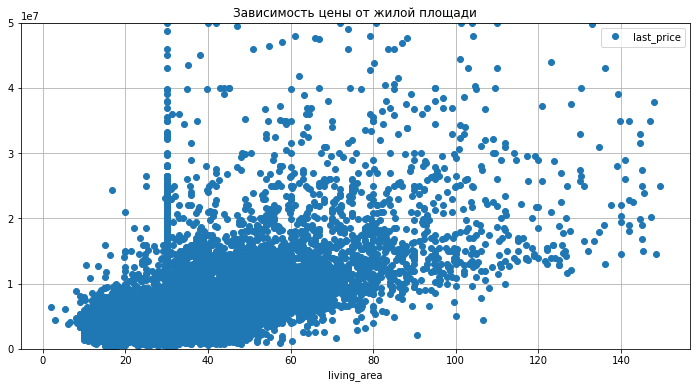

In [44]:
# Строим диаграмму рассеяния для исследования зависимости цены на недвижимость от ее жилой площади.
(data
    .query('living_area < 150')
    .plot(x='living_area', y='last_price', 
          ylim=(0, 50000000), style='o', grid=True, figsize=(12, 6))
)
plt.title('Зависимость цены от жилой площади')
plt.show()

На графике видно, что стоимость недвижимости площадью более 110 кв м не опускается ниже 10 млн р.

Коэффициент корреляции равен 0.5486078633278703


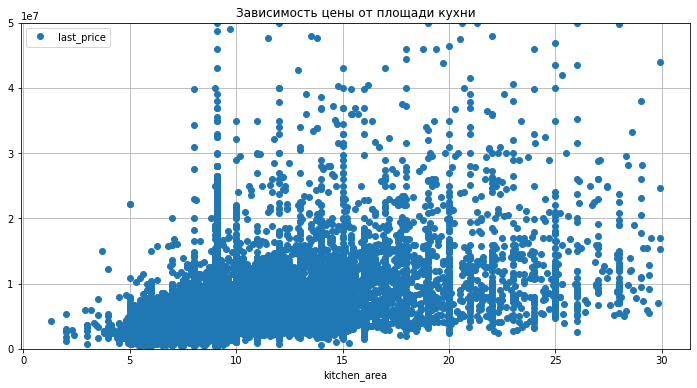

In [45]:
# Переходим к исследованию зависимости цены от площади кухни

print('Коэффициент корреляции равен', data['last_price'].corr(data['kitchen_area']))

(data
     .query('kitchen_area < 30')
     .plot(x='kitchen_area', y='last_price',
          ylim=(0, 50000000), style='o', grid=True, figsize=(12, 6))
)
plt.title('Зависимость цены от площади кухни')
plt.show()

Судя по графику, можно сказать, что зависимость цены объекта от площади кухни незначительна. Тем не менее, цена квартиры растет (совсем немного) с увеличением площади ее кухни.

Коэффициент корреляции равен 0.4657453217477878


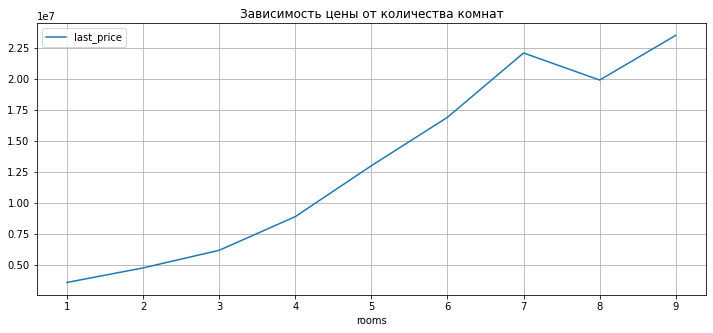

In [46]:
# Изучаем зависимость цены от количества комнат
# вариант построения графика с помощью сводной таблицы из материалов урока по визуализации

print('Коэффициент корреляции равен', data['last_price'].corr(data['rooms']))

(
    data.query('last_price < 50000000 and 0 < rooms < 10')
    .pivot_table(index='rooms', values='last_price', aggfunc='median')
    .plot(style = '-', grid=True, figsize=(12, 5))
);
plt.title('Зависимость цены от количества комнат')
plt.show()

На графике видно, что в среднем медианные значения цен на квартиры растут вместе с увеличением количества комнат.

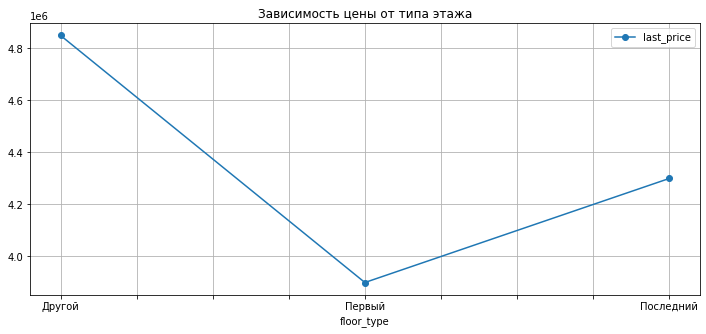

In [47]:
# Зависимость цены от этажа, на котором находится объект

(
    data.query('last_price < 50000000')
        .pivot_table(index = 'floor_type', values = 'last_price', aggfunc = 'median')
        .plot(style = 'o-', grid=True, figsize = (12, 5))
);
plt.title('Зависимость цены от типа этажа')
plt.show()

Квартиры, расположенные на первом и на последнем этаже существенно дешевле остальных. При этом, наиболее дешевые объекты находятся на первом этаже. Отсюда следует вывод о том, что цена квартиры существенно зависит от этажа, на котором она расположена. 

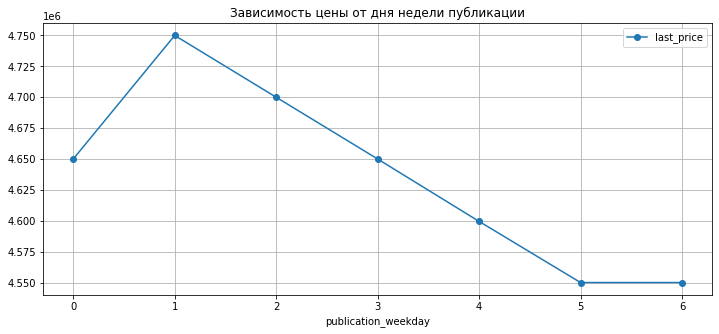

In [48]:
# Зависимость цены от дня недели публикации
(
    data.query('last_price < 50000000')
        .pivot_table(index = 'publication_weekday', values = 'last_price', aggfunc = 'median')
        .plot(style = 'o-', grid=True, figsize = (12, 5))
);
plt.title('Зависимость цены от дня недели публикации')
plt.show()

На графике видно, что публикации о продаже более дорогих объектов появляются чаще всего в начале недели, а публикации о продаже наиболее дешевых квартир - в конце недели. 

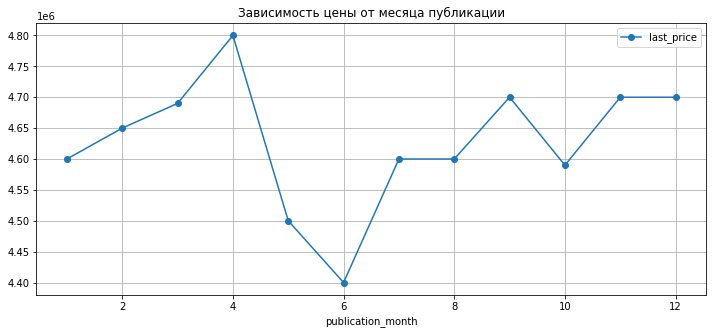

In [49]:
# Зависимость цены от месяца публикации
(
    data.query('last_price < 50000000')
        .pivot_table(index = 'publication_month', values = 'last_price', aggfunc = 'median')
        .plot(style = 'o-', grid=True, figsize = (12, 5))
);
plt.title('Зависимость цены от месяца публикации')
plt.show()

В среднем, объявления о продаже самых дорогих квартир выложены в апреле, а самых дешевых - в мае и июне.

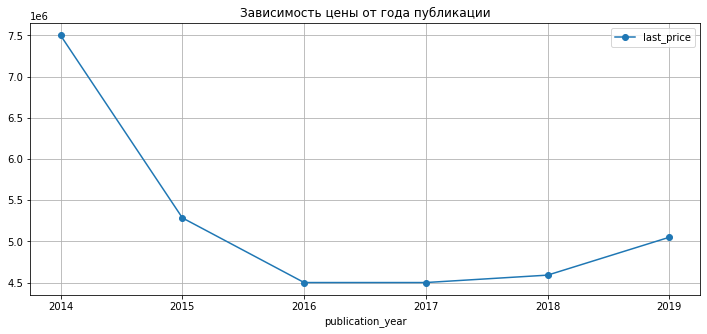

In [50]:
# Зависимость цены от года публикации
(
    data.query('last_price < 50000000')
        .pivot_table(index = 'publication_year', values = 'last_price', aggfunc = 'median')
        .plot(style = 'o-', grid=True, figsize = (12, 5))
);
plt.title('Зависимость цены от года публикации')
plt.show()

Цены на квартиры сильно упали после 2014 года, но начали расти с 2018 года.

In [51]:
# Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

locality_top = data['locality_name'].value_counts().sort_values(ascending=False).head(10)
display(locality_top)

Санкт-Петербург      15529
поселок Мурино         528
поселок Шушары         436
Всеволожск             391
Пушкин                 369
Колпино                338
поселок Парголово      323
Гатчина                306
деревня Кудрово        283
Выборг                 235
Name: locality_name, dtype: int64

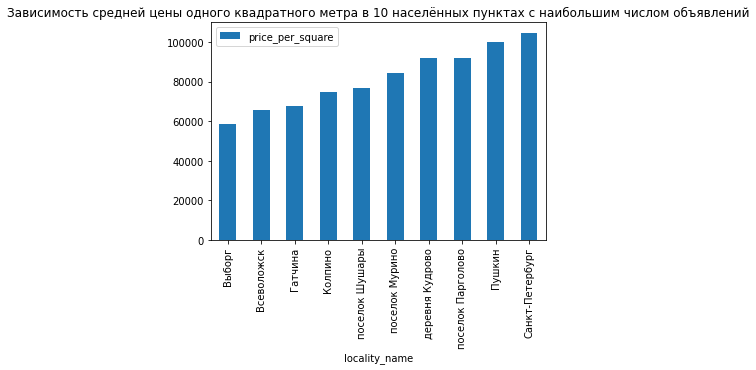

In [52]:
# Построим столбчатую диаграмму. 
(
    data.query('locality_name in @locality_top.index')
        .pivot_table(index='locality_name', values='price_per_square', aggfunc='median')
        .sort_values('price_per_square')
        .plot(kind='bar')
);
plt.title('Зависимость средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений')
plt.show()

Самая высокая цена за квадратный метр у квартир Санкт-Петербурга, а самая низкая цена за квадратный метр в Выборге.

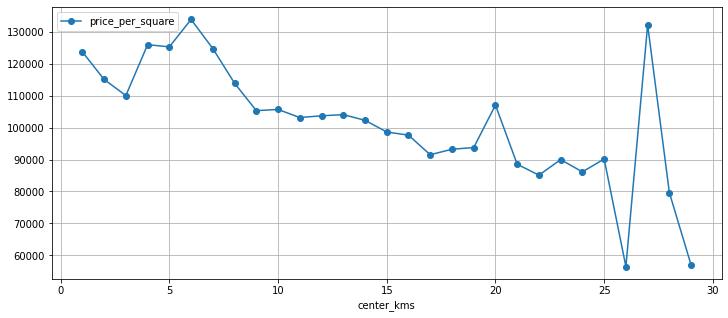

In [54]:
# Отразим среднюю цену каждого километра для квартир в Санкт-Петербурге на графике

(
    data.query('locality_name == "Санкт-Петербург"')
        .pivot_table(index = 'center_kms', values = 'price_per_square', aggfunc = 'median')
        .plot(style = 'o-', grid=True, figsize = (12, 5))
);


Как мы можем видеть на графике, самая высокая средняя стоимость километра от центра у тех квартир, которые расположены ближе всего к центру. Цены за каждый километр от центра в среднем не меняется для квартир, расположенных от центра дальше чем на 10 км. Мы можем сделать вывод: чем дальше от центра города расположена квартира, тем ниже её общая стоимость.



### Общий вывод

1) В ходе исследовательского анализа объявлений о продаже квартир была изучена и обработана таблица из 23699 строк и 22 столбцов: 

    - Датасет проверен на количество и долю (в процентах) пропусков в каждом столбце. Устранены пропуски в столбцах 'is_apartment', 'balcony', 'kitchen_area', 'locality_name', 'ceiling_height', 'floors_total', 'living_area'; 
    - В столбцах 'balcony', 'floors_total' и 'first_day_exposition' был изменен тип данных;
    - В столбце 'locality_name' были выявлены и устранены неявные дубликаты;
    - Аномальные значения в столбцах со значениями стоимости квартир, количеством комнат и общей площадью были также выявлены и отброшены. 

   В результате предобработки данных удалено 347 строк, что составляет всего 1.4%.

2) После предобработки в датасет были добавлены столбцы с необходимой для анализа информацией:
    
    - цена одного квадратного метра;
    - день публикации объявления;
    - месяц публикации объявления;
    - год публикации объявления;
    - тип этажа квартиры;
    - расстояние в км до центра города;
    
3) Далее были изучены и описаны параметры общей площади, жилой площади, площади кухни, цены объектов, количества комнат, высоты потолков, этажа квартиры, общего количества этажей в домах, дня и месяца публикаций, а также расстояния от объекта до ближайшего аэропорта, парка и центра города. Для каждого параметра построен график (гистограмма), в результате анализа которых можно сделать несколько выводов:
    
    - Среди 23352 квартир больше всего помещений площадью около 60 кв.м, большая часть квартир имеет жилую площадь около 34 кв.м, площадь кухни в среднем составляет 10.4 кв.м;
    - Большая часть квартир была продана примерно за 6.25 млн рублей;
    - Наибольшая часть квартир в таблице - однокомнатные и двухкомнатные;
    - Средняя высота потолка равна 2.6 м;
    - Больше всего объявлений о продаже квартир, расположенных на втором этаже;
    - Наибольшая часть квартир расположена ни на первом, ни на последнем этажах. Квартир на последнем этаже немного больше, чем квартир с первого этажа;
    - Среди объявлений, представленных в таблице, наибольшее количество зданий имеет 5 и 9 этажей;
    - Большинство квартир расположено на расстоянии от 10 до 15 км до центра города, от 20 до 25 км до ближайшего аэропорта и около 1 км до ближайшего парка;
    - Объявления реже публикуются в выходные дни. Чаще всего объявления о продаже публикуются во вторник и четверг. Меньше всего объявлений опубликовано в мае, январе и декабре, а больше всего в феврале, марте, апреле и ноябре.
    
4) Далее была исследована скорость продажи квартир. В результате исследования можно сказать, что продажа квартиры занимает обычно от сорока до двухсот дней с момента публикации объявления. В таблице представлены квартиры, которые были проданы как быстрее обычного (до 40 дней), так и намного дольше (более 4 лет). Среднее время, которое "висит" объявление о продаже квартиры, равняется примерно 180 дням. В то же время медианное значение равно 95. Медиана более устойчива к аномальным значениям и выбросам, а значит является более объективным показателем.

5) Следующим этапом исследования был анализ зависимости общей стоимости квартиры от её площади, площади кухни, количества комнат, типа этажа, на котором она расположена, а также даты размещения объявления о ее продаже. Выводы следующие:

    - Цена квартиры значительно зависит от её общей и жилой площади, от количества комнат и типа этажа (самые дешевые квартиры расположены на первом этаже);
    - Цена квартиры практически не зависит от площади её кухни;
    - Объявления о продаже наиболее дорогих квартир появляются чаще всего в начале недели, а публикации о продаже наиболее дешевых квартир - в конце недели. Дороже всего квартиры были проданы в апреле, а самые дешевые были проданы в мае и июне. Цены на квартиры сильно упали после 2014 года, но начали расти с 2018 года.

6) Далее была успешно посчитана средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Оказалось, что самая высокая цена за квадратный метр у квартир Санкт-Петербурга, а самая низкая цена за квадратный метр в Выборге.

7) Заключительным этапом исследования стал анализ средней стоимости каждого километра от объекта до центра Санкт-Петербурга. В результате анализа можно сделать логичный вывод о том, что чем дальше от центра города расположена квартира, тем ниже её общая стоимость.